### Imports

In [0]:
import os, shutil
from google.colab import drive
from keras import layers
from keras import models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import np_utils
from sklearn.utils import shuffle

### Set-up Big Query

In [87]:
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
project_id = 'calgaryhacks'

client = bigquery.Client(project=project_id)

Authenticated


In [0]:
def query_Creator():
  theQuery = 'SELECT * FROM `calgaryhacks.2016_usage.2016_usage` WHERE date like "%-12-%" ORDER BY date'
  return theQuery

In [413]:
# date = "1"
query = query_Creator()
day_data = shuffle(client.query(query).to_dataframe())

print(day_data)

                 date hour  temp     usage
81   2016-12-04 09:00   09  -4.3  0.296475
263  2016-12-11 23:00   23 -16.6  0.346197
392  2016-12-17 08:00   08 -22.8  0.338103
262  2016-12-11 22:00   22 -16.1  0.426225
307  2016-12-13 19:00   19 -15.9  0.478791
516  2016-12-22 12:00   12   5.9  0.288423
222  2016-12-10 06:00   06 -23.7  0.292653
117  2016-12-05 21:00   21 -18.8  0.416196
565  2016-12-24 13:00   13 -12.6  0.375654
488  2016-12-21 08:00   08   1.1  0.307047
32   2016-12-02 08:00   08  -8.1  0.257430
183  2016-12-08 15:00   15 -20.1  0.320025
312  2016-12-14 00:00   00 -19.1  0.280779
102  2016-12-05 06:00   06 -16.7  0.282915
366  2016-12-16 06:00   06 -24.1  0.301638
374  2016-12-16 14:00   14 -17.8  0.338250
28   2016-12-02 04:00   04  -7.4  0.193677
561  2016-12-24 09:00   09 -11.1  0.354309
317  2016-12-14 05:00   05 -19.7  0.273405
352  2016-12-15 16:00   16 -17.1  0.394176
541  2016-12-23 13:00   13  -5.9  0.339741
453  2016-12-19 21:00   21  -1.6  0.387717
123  2016-1

### Slice the data intro train features and labels

In [414]:
train_data = day_data.iloc[:,1:3].astype('float32')
train_labels = day_data.iloc[:, 3].astype('float32')
print(train_data)

     hour       temp
81    9.0  -4.300000
263  23.0 -16.600000
392   8.0 -22.799999
262  22.0 -16.100000
307  19.0 -15.900000
516  12.0   5.900000
222   6.0 -23.700001
117  21.0 -18.799999
565  13.0 -12.600000
488   8.0   1.100000
32    8.0  -8.100000
183  15.0 -20.100000
312   0.0 -19.100000
102   6.0 -16.700001
366   6.0 -24.100000
374  14.0 -17.799999
28    4.0  -7.400000
561   9.0 -11.100000
317   5.0 -19.700001
352  16.0 -17.100000
541  13.0  -5.900000
453  21.0  -1.600000
123   3.0 -19.700001
266   2.0 -18.100000
501  21.0   2.300000
504   0.0   2.800000
364   4.0 -20.700001
691  19.0  -4.800000
61   13.0   4.600000
671  23.0  -3.200000
..    ...        ...
51    3.0   1.800000
418  10.0  -2.200000
141  21.0 -19.500000
568  16.0 -13.700000
365   5.0 -22.299999
214  22.0 -22.700001
735  15.0  -3.800000
525  21.0   1.700000
461   5.0  -0.900000
695  23.0  -3.300000
240   0.0 -23.500000
346  10.0 -18.700001
553   1.0  -8.000000
559   7.0 -10.400000
669  21.0  -3.800000
259  19.0 -17

### Specifying the model

In [0]:
# Define the network
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu', input_shape=(2,)))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse')
    return model

In [416]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 200)               600       
_________________________________________________________________
dense_137 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_138 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 201       
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [0]:
for i in range(1,200):
  model_name = 'predictor_64Nodes_Januarys_i'+str(i)+'.h5'
  print(model_name)
  model.fit(train_data, train_labels, epochs=100, verbose=2, batch_size=32)
  the_result = model.evaluate(train_data, train_labels)
  print(the_result)

In [427]:
model.fit(train_data, train_labels, epochs=50, verbose=0, batch_size=32)
the_result = model.evaluate(train_data, train_labels)
print(the_result)
model.save('predictor_December.h5')

744/744 [==============================] - 0s 50us/step
0.0007556160706626152


### Visualize the data

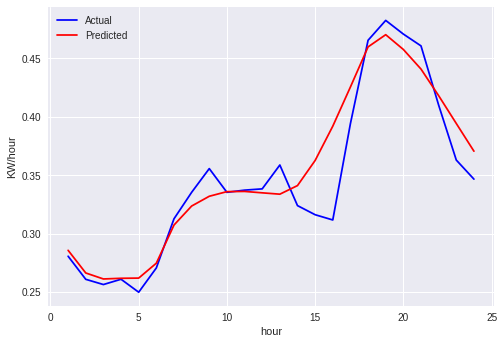

In [441]:
validation_query = 'SELECT * FROM `calgaryhacks.2016_usage.2016_usage` WHERE date like "%-12-15%" ORDER BY date'
validation_data = client.query(validation_query).to_dataframe()
actual = np.array(validation_data.iloc[:,3])
prediction = np.array(validation_data.iloc[:,1:3])

predictions = model.predict(prediction)

plt.plot(range(1, 25), actual, 'b', label='Actual')
plt.plot(range(1, 25), predictions, 'r', label='Predicted')
plt.xlabel('hour')
plt.ylabel('KW/hour')
plt.legend()
plt.show()